In [1]:
from os import getcwd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch as t
import math

from distributions import DiscretizedMixtureLogitsDistribution
from vae import VAE
from vae_small import VAE_SMALL
from train import train
from data import PokemonIMG
from loss import elbo

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the architecture

In [3]:
z_size = 256
vae_hid = 128
n_mixtures = 1
batch_size = 32
dmg_size = 16
p_update = 1.0
min_steps, max_steps = 64, 128

encoder_hid = 32
h = w = 32
n_channels = 3

## Define the distribution to use for $p_{\theta}(x|z)$

In [4]:
n_mixtures = 1

# input 'state' should have as shape (batch_size, z_space, height, width)
def state_to_dist(state):
    return DiscretizedMixtureLogitsDistribution(n_mixtures, state[:, :n_mixtures * 10, :, :])

## Pre-process the data

In [5]:
dset = PokemonIMG()

num_samples = len(dset)
train_split = 0.7
val_split = 0.2
test_split = 0.1

num_train = math.floor(num_samples*train_split)
num_val = math.floor(num_samples*val_split)
num_test = math.floor(num_samples*test_split)
num_test = num_test + (num_samples - num_train - num_val - num_test)

train_set, val_set, test_set = t.utils.data.random_split(dset, [num_train, num_val, num_test])

## Instantiate the VAE

In [6]:
vae = VAE(h, w, n_channels, z_size, train_set, val_set, test_set, state_to_dist, batch_size, p_update, min_steps, max_steps, encoder_hid)
#vae_small = VAE_SMALL(h, w, n_channels, z_size, train_set, val_set, test_set, state_to_dist, batch_size, encoder_hid)

VAE(
  (conv2d1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2d2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d4): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2d5): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (elu): ELU(alpha=1.0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=512, bias=True)
  (dec_lin): Linear(in_features=256, out_features=4096, bias=True)
  (conv_t2d1): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (conv_t2d4): ConvTranspose2d(128, 64, kernel_

## Load in the parameters from the trained VAE

In [7]:
param_path = join(getcwd(), "latest_VAE")
#param_path = join(getcwd(), "latest_VAE_SMALL")

vae.load(param_path)
#vae_small.load(param_path)

# Plotting novel samples

In [8]:
samples = vae.p_z.sample((8,)).to(vae.device)
states = vae.decode(samples)
print(len(states))

8


In [9]:
image, mean = vae.to_rgb(states[0].unsqueeze(0))
print(image.shape)

torch.Size([1, 3, 32, 32])


c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'distributions.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


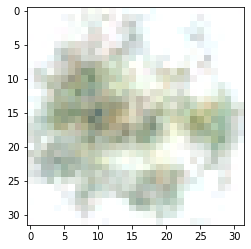

In [10]:
plt.imshow(image.squeeze(0).permute(1,2,0).cpu().detach().numpy())

# Plotting reconstructions

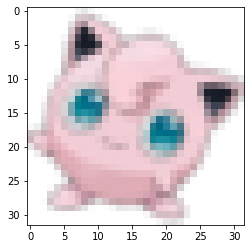

In [11]:
dset = PokemonIMG()

img, label = dset.find("39.png")

plt.imshow(img.permute(1, 2, 0).cpu().detach().numpy())

Forward the image through the network

In [12]:
img, label = dset.find("39.png")

loss, z, p_x_given_z, recon_loss, kl_loss, state = vae.forward(img.unsqueeze(0), 1, elbo)

c:\Users\jsche\anaconda3\envs\torch\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class 'distributions.DiscretizedMixtureLogitsDistribution'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Turn the decoded state into an image

In [14]:
img, mean = vae.to_rgb(state)

Plot the image

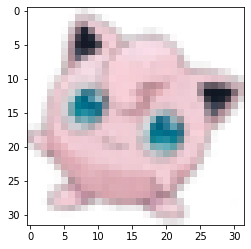

In [16]:
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())